In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('scanner_data.csv')
df

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [ ]:
df.isna().sum()

Unnamed: 0        0
Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

## 1. EDA

## 2. Filtering Data

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y')
df

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,2016-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2,2016-01-02,822,2,2ML,68BRQ,1.0,5.46
2,3,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,4,2016-01-02,3719,4,0H2,549KK,1.0,5.59
4,5,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,2016-07-04,20203,32900,IEV,FO112,3.0,6.46
131702,131703,2016-07-04,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,2016-07-04,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,2016-07-04,20203,32900,0H2,ZVTO4,1.0,4.57


In [ ]:
df['Date'].min()

Timestamp('2016-01-02 00:00:00')

In [ ]:
df['Date'].max()

Timestamp('2016-12-31 00:00:00')

In [ ]:
reference_date = df['Date'].max() + dt.timedelta(days=1)

<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');

body,
div,
h1,
h2,
h3,
h4,
h5,
h6,
p,
span,
label,
input,
textarea,
button,
pre,
code,
kbd,
samp {
    font-family: 'Poppins', sans-serif !important;
}
</style>
## 3. RFM Scoring

Once we have the RFM metrics, we assign a score between 1 and 5 for each metric. The scores are based on quintiles:
- **Recency**: Lower recency (more recent purchase) gets a higher score.
- **Frequency**: Higher frequency (more purchases) gets a higher score.
- **Monetary**: Higher monetary value (more money spent) gets a higher score.

These scores are then combined to create an RFM score for each customer.

In [ ]:
# Aggregate the data with descriptive column names
rfm_df = df.groupby('Customer_ID').agg(
    Last_Purchase_Date=('Date', 'max'),  # Get the date of the most recent transaction
    Frequency=('Transaction_ID', 'nunique'), # Count the total number of transactions
    Monetary=('Sales_Amount', 'sum') # Sum the total amount spent
).reset_index()

# Calculate Recency as the number of days between the reference date and the last purchase date
rfm_df['Recency'] = (reference_date - rfm_df['Last_Purchase_Date']).dt.days

# Reorder columns to have Recency in the correct place
rfm_df = rfm_df[['Customer_ID', 'Recency', 'Frequency', 'Monetary']]

rfm_df.head()

,Customer_ID,Recency,Frequency,Monetary
0,1,345,1,16.29
1,2,196,2,22.77
2,3,365,1,10.92
3,4,53,2,33.29
4,5,180,5,78.82


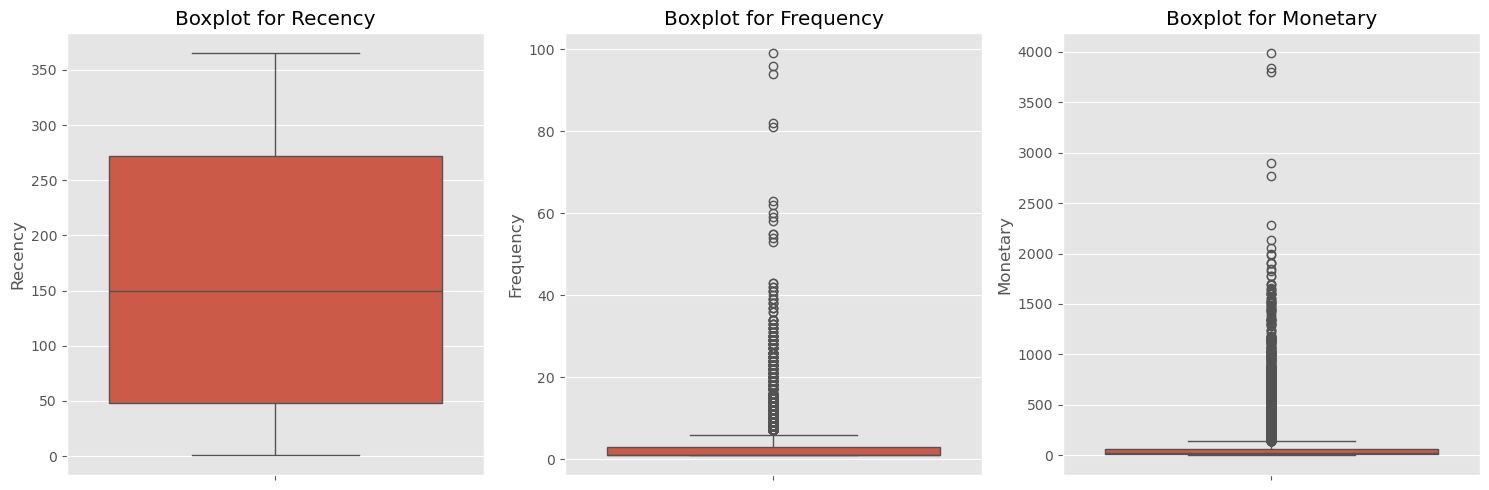

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use("ggplot")

# Create a figure with subplots for Recency, Frequency, and Monetary
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot for Recency
sns.boxplot(y=rfm_df['Recency'], ax=axes[0])
axes[0].set_title('Boxplot for Recency')
axes[0].set_ylabel('Recency')

# Boxplot for Frequency
sns.boxplot(y=rfm_df['Frequency'], ax=axes[1])
axes[1].set_title('Boxplot for Frequency')
axes[1].set_ylabel('Frequency')

# Boxplot for Monetary
sns.boxplot(y=rfm_df['Monetary'], ax=axes[2])
axes[2].set_title('Boxplot for Monetary')
axes[2].set_ylabel('Monetary')

# Display the plots
plt.tight_layout()
plt.show()

<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');

body,
div,
h1,
h2,
h3,
h4,
h5,
h6,
p,
span,
label,
input,
textarea,
button,
pre,
code,
kbd,
samp {
    font-family: 'Poppins', sans-serif !important;
}
</style>
## 3. RFM Scoring

Once we have the RFM metrics, we assign a score between 1 and 5 for each metric. The scores are based on quintiles:
- **Recency**: Lower recency (more recent purchase) gets a higher score.
- **Frequency**: Higher frequency (more purchases) gets a higher score.
- **Monetary**: Higher monetary value (more money spent) gets a higher score.

These scores are then combined to create an RFM score for each customer.

In [ ]:
rfm_df['Recency_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['Frequecy_Score'] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_df['Monetary_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [ ]:
rfm_df

,Customer_ID,Recency,Frequency,Monetary,Recency_Score,Frequecy_Score,Monetary_Score
0,1,345,1,16.29,1,1,2
1,2,196,2,22.77,3,3,3
2,3,365,1,10.92,1,1,2
3,4,53,2,33.29,4,3,3
4,5,180,5,78.82,3,5,4
...,...,...,...,...,...,...,...
22620,22621,22,1,9.69,5,3,2
22621,22622,16,1,6.07,5,3,1
22622,22623,11,1,128.01,5,3,5
22623,22624,30,1,19.60,5,3,3


<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');

body,
div,
h1,
h2,
h3,
h4,
h5,
h6,
p,
span,
label,
input,
textarea,
button,
pre,
code,
kbd,
samp {
    font-family: 'Poppins', sans-serif !important;
}
</style>
## 4. Combine RFM Scores

The next step involves combining the Recency, Frequency, and Monetary scores into a single RFM score. This score is generated by concatenating the Recency, Frequency, and Monetary scores for each customer. The resulting RFM score gives a comprehensive view of a customer’s behavior in terms of their engagement and value.

In [ ]:
rfm_df['RFM_Score'] = rfm_df.Recency_Score.astype(str) + rfm_df.Frequecy_Score.astype(str) + rfm_df.Monetary_Score.astype(str)

rfm_df

,Customer_ID,Recency,Frequency,Monetary,Recency_Score,Frequecy_Score,Monetary_Score,RFM_Score
0,1,345,1,16.29,1,1,2,112
1,2,196,2,22.77,3,3,3,333
2,3,365,1,10.92,1,1,2,112
3,4,53,2,33.29,4,3,3,433
4,5,180,5,78.82,3,5,4,354
...,...,...,...,...,...,...,...,...
22620,22621,22,1,9.69,5,3,2,532
22621,22622,16,1,6.07,5,3,1,531
22622,22623,11,1,128.01,5,3,5,535
22623,22624,30,1,19.60,5,3,3,533


<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');

body,
div,
h1,
h2,
h3,
h4,
h5,
h6,
p,
span,
label,
input,
textarea,
button,
pre,
code,
kbd,
samp {
    font-family: 'Poppins', sans-serif !important;
}
</style>
## 5. RFM Segmentation

In this step, we use combined RFM scores to segment customers into various groups. Each segment represents different customer behaviors based on recency, frequency, and monetary value.

Here are the common segments used in RFM analysis:

- **Hibernating**: Customers who have not made a purchase in a long time, with low frequency and monetary value.
- **At Risk**:  Previously active customers who have not made a purchase for a while, indicating potential churn or loss.
- **Cannot Lose Them**: Customers with high monetary value but low purchase frequency and who have not made a purchase for a long time, requiring special attention to prevent loss.
- **About to Sleep**: Customers with moderate recency and frequency who might stop transacting if not reactivated.
- **Need Attention**: Customers with good potential who need more attention and engagement to boost their activity.
- **Promising**: New customers who have the potential to become loyal or high-value customers.
- **Champion**: Top customers who purchase frequently, have made a recent purchase, and have high spending.
- **Loyal Customer**: Loyal customers who purchase frequently and have high monetary value.
- **Potential Loyalist**: Customers who are almost loyal but not fully, possibly with high frequency but still medium monetary value.
- **New Customers**: Customers who have just made a purchase and may still be exploring the product or brand.
- **Lost**: Customers who have not purchased in a long time, with low frequency and monetary value, and are likely to be lost or churn.

In [ ]:
# Create customer segments based on RFM score
Champion = [555, 554, 544, 545, 454, 455, 445]
Loyal_Customer = [543, 444, 435, 355, 354, 345, 344, 335]
Potential_Loyalist = [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323]
New_Customer = [512, 511, 422, 421, 412, 411, 311]
Promising = [525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313]
Need_Attention = [535, 534, 443, 434, 343, 334, 325, 324]
Cannot_Lose_Them = [155, 154, 144, 214,215,115, 114, 113]
About_to_Sleep = [331, 321, 312, 221, 213]
At_Risk = [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124]
Hibernating = [332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211]
Lost = [111, 112, 121, 131, 141, 151]

# Create a function to assign customers to various customer segments based on RFM score
def assign_cust_seg(col):
    list_col = list(col)
    segment = list()
    for score in list_col:
        if score in Champion:
            value = 'Champion'
        elif score in Loyal_Customer:
            value = 'Loyal Customer'
        elif score in Potential_Loyalist:
            value = 'Potential Loyalist'
        elif score in New_Customer:
            value = 'New Customer'
        elif score in Promising:
            value = 'Promising'
        elif score in Need_Attention:
            value = 'Need Attention'
        elif score in Cannot_Lose_Them:
            value = 'Cannot Lose Them'
        elif score in About_to_Sleep:
            value = 'About to Sleep'
        elif score in At_Risk:
            value = 'At Risk'
        elif score in Hibernating:
            value = 'Hibernating'
        elif score in Lost:
            value = 'Lost'
        else:
            value = 'null'
        segment.append(value)
    return segment

# Assign customers to segments based on their RFM score
rfm_df['Customer Segment'] = assign_cust_seg(rfm_df['RFM_Score'].astype(int))
rfm_df.head(5)

,Customer_ID,Recency,Frequency,Monetary,Recency_Score,Frequecy_Score,Monetary_Score,RFM_Score,Customer Segment
0,1,345,1,16.29,1,1,2,112,Lost
1,2,196,2,22.77,3,3,3,333,Potential Loyalist
2,3,365,1,10.92,1,1,2,112,Lost
3,4,53,2,33.29,4,3,3,433,Potential Loyalist
4,5,180,5,78.82,3,5,4,354,Loyal Customer


In [ ]:
pd.DataFrame(rfm_df['Customer Segment'].value_counts())

,count
Customer Segment,
Champion,3823
Hibernating,3178
Potential Loyalist,2915
At Risk,2507
Lost,1943
Loyal Customer,1912
About to Sleep,1578
Cannot Lose Them,1325
Need Attention,1277


<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700&display=swap');

body,
div,
h1,
h2,
h3,
h4,
h5,
h6,
p,
span,
label,
input,
textarea,
button,
pre,
code,
kbd,
samp {
    font-family: 'Poppins', sans-serif !important;
}
</style>
## 6. Analyze the Segments

Once customers are segmented, we analyze each segment to understand their behavior:
- **Recency**: How recently customers in each segment have purchased.
- **Frequency**: How often customers in each segment make purchases.
- **Monetary**: How much customers in each segment spend.

This analysis provides insights into which customer groups need more attention and which are high-value, helping businesses tailor their marketing strategies.

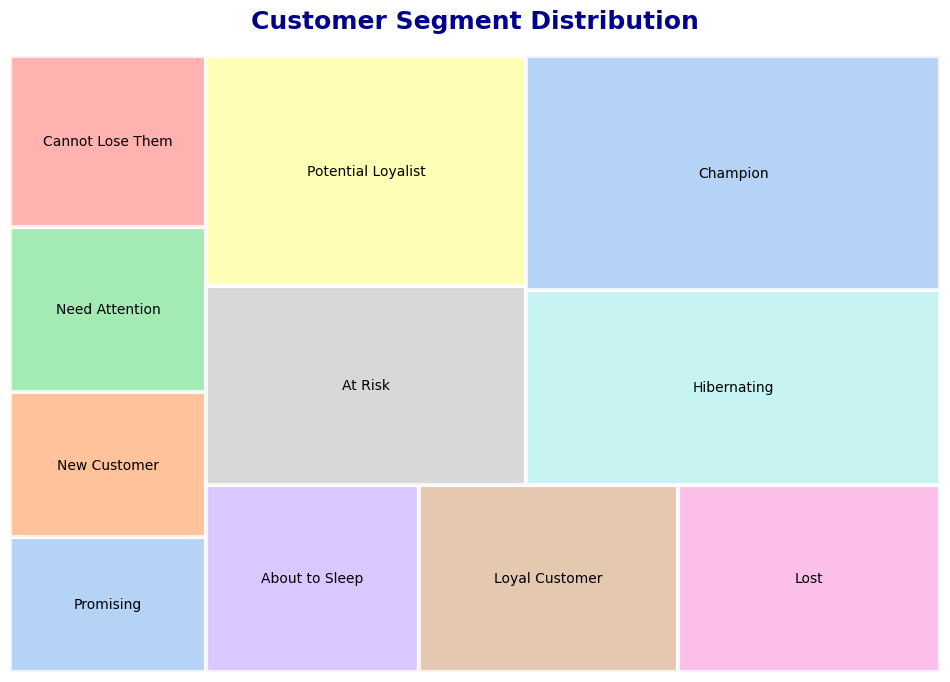

In [ ]:
segment_counts = rfm_df['Customer Segment'].value_counts().reset_index()
segment_counts.columns = ['Customer Segment', 'count']
segment_counts = segment_counts.sort_values(by='count', ascending=True)
colors = sns.color_palette('pastel', len(segment_counts))

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=segment_counts['count'],
    label=segment_counts['Customer Segment'],
    color=colors,
    alpha=0.8,
    edgecolor='white',
    linewidth=3
)

plt.axis('off')
plt.title(
    'Customer Segment Distribution',
    fontsize=18,
    fontweight='bold',
    color='darkblue',
    pad=20
)

plt.show()


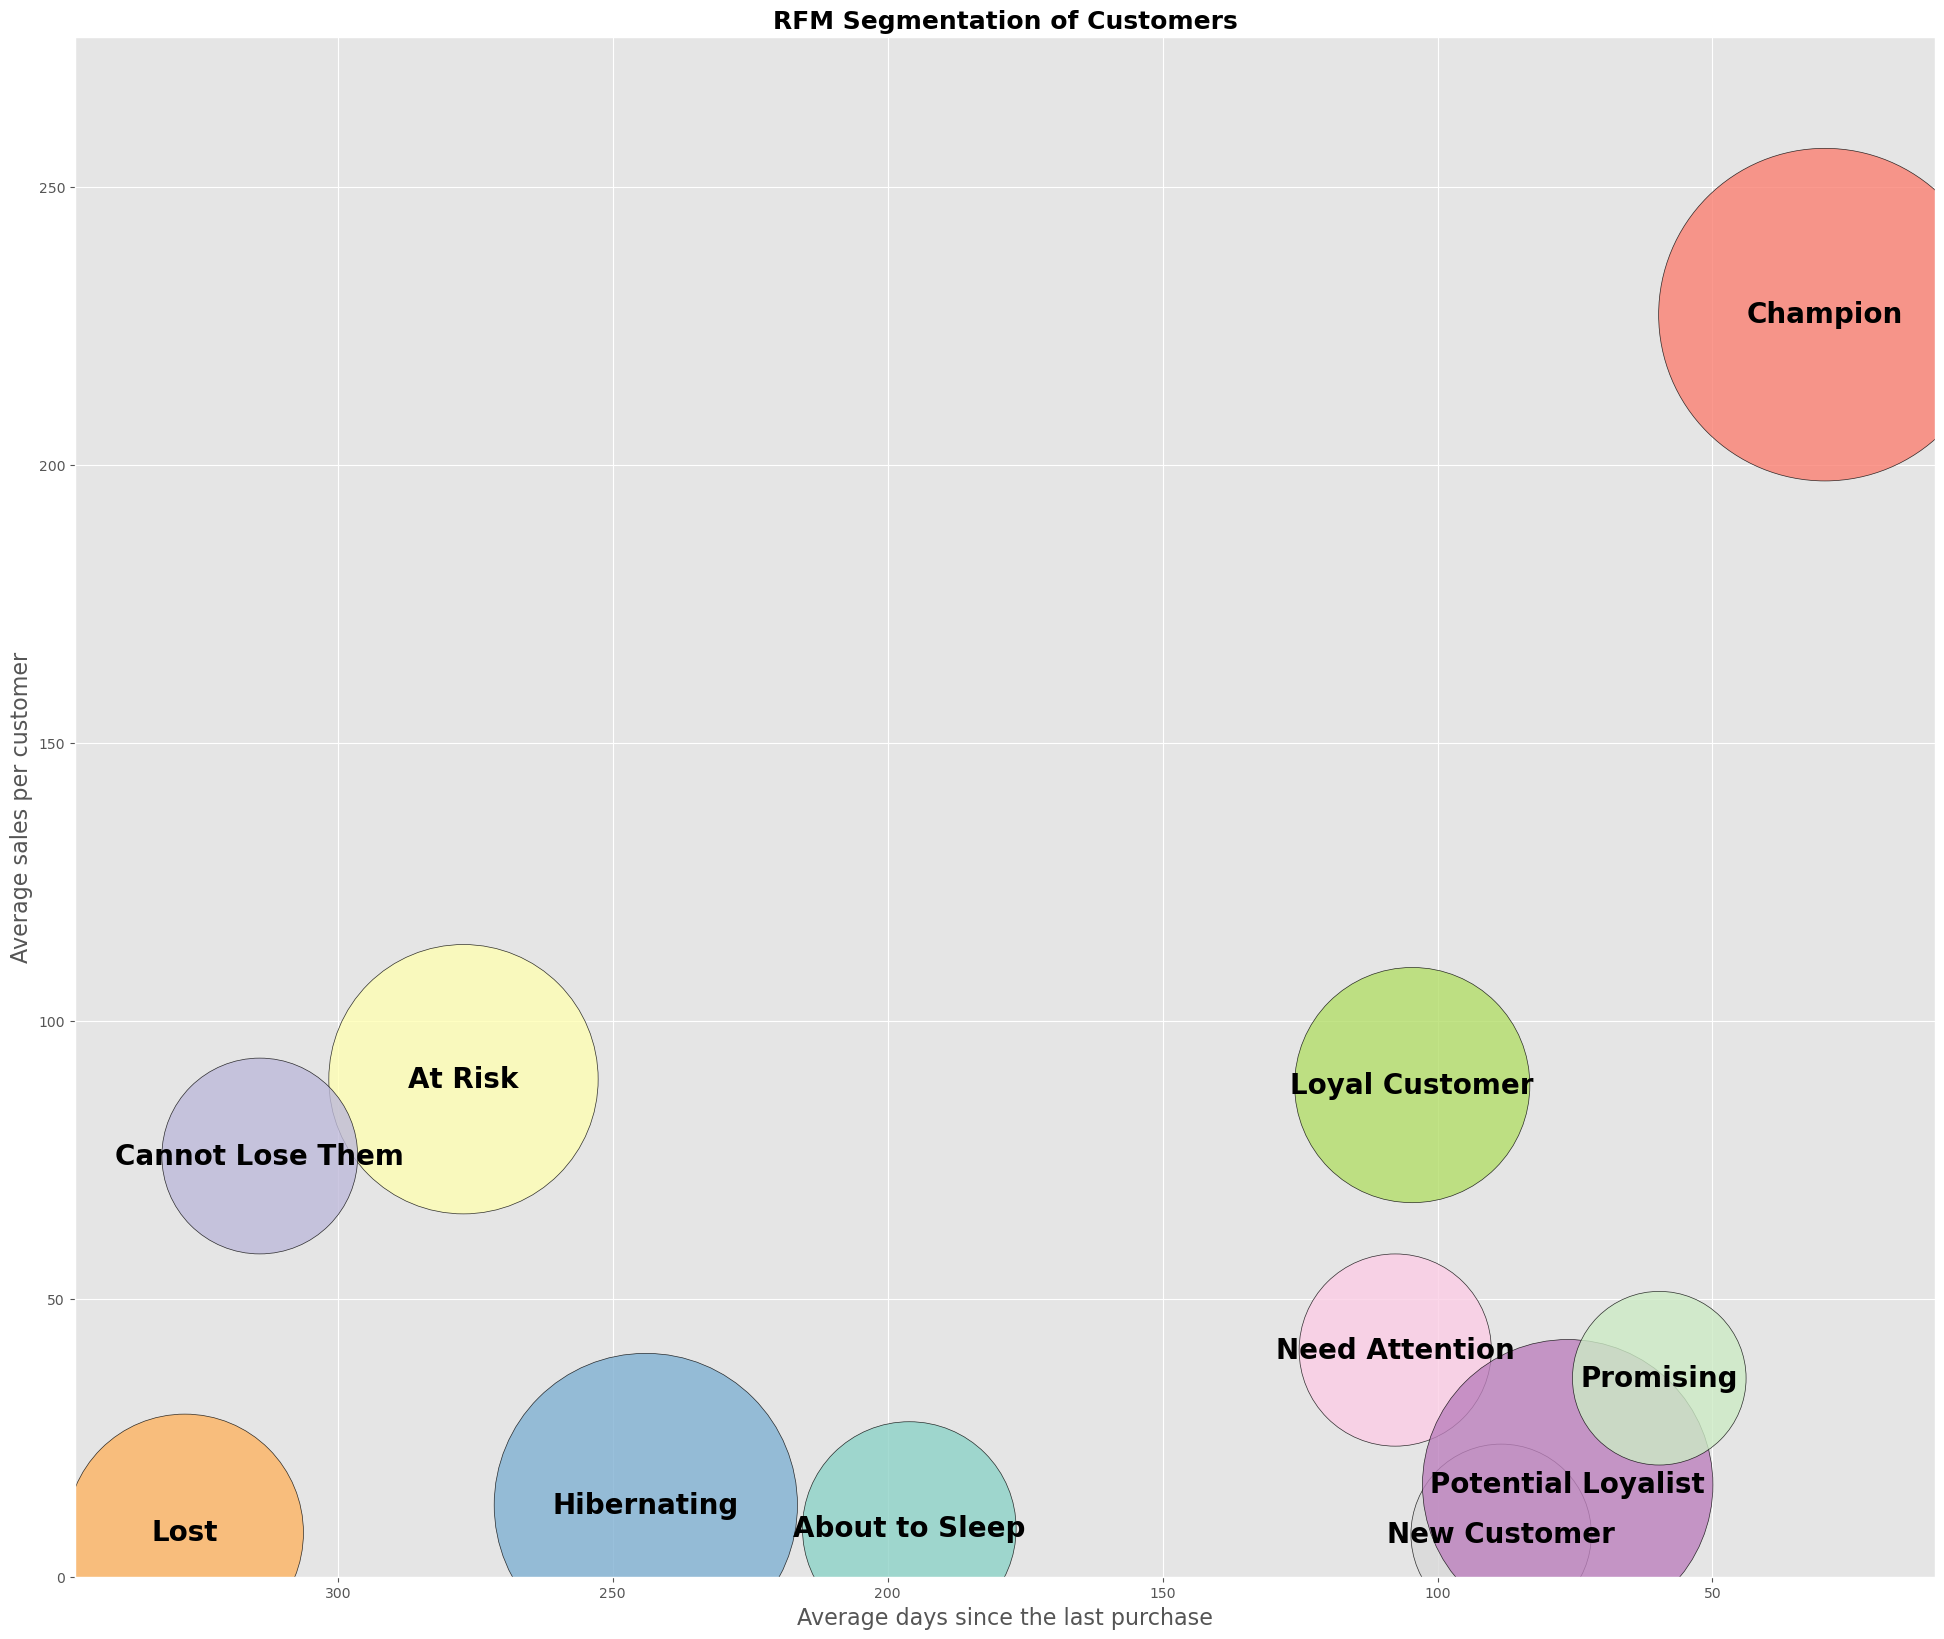

In [ ]:
segment_summary = rfm_df.groupby('Customer Segment').agg(
    avg_days_since_purchase=('Recency', 'mean'),
    avg_sales_per_customer=('Monetary', 'mean'),
    customer_count=('Customer_ID', 'count')
).reset_index()

plt.figure(figsize=(24, 20))

colors = sns.color_palette('Set3', n_colors=len(segment_summary))
scatter = plt.scatter(
    x=segment_summary['avg_days_since_purchase'],
    y=segment_summary['avg_sales_per_customer'],
    s=segment_summary['customer_count'] * 15,
    c=colors,
    alpha=0.8,
    edgecolors='black'
)

plt.xlabel('Average days since the last purchase', fontsize=16)
plt.ylabel('Average sales per customer', fontsize=16)
plt.title('RFM Segmentation of Customers', fontsize=18, fontweight='bold')
plt.grid(True)

for i, row in segment_summary.iterrows():
    plt.annotate(
        row['Customer Segment'],
        (row['avg_days_since_purchase'], row['avg_sales_per_customer']),
        ha='center',
        va='center',
        fontsize=20,
        weight='bold'
    )

plt.gca().invert_xaxis()

# Adjust limits for better spacing
plt.xlim(segment_summary['avg_days_since_purchase'].max() + 20, segment_summary['avg_days_since_purchase'].min() - 20)
plt.ylim(0, segment_summary['avg_sales_per_customer'].max() + 50)

# Display the plot
plt.show()


Insights

* Customers do not remain static in their assigned segments. A Loyal Customer today can shift to At Risk or Need Attention if not nurtured properly.
* Conversely, an At Risk or Hibernating customer can be reactivated with the right strategies.

In [ ]:
# Step 1: Extract Customer_IDs for Champion segment
champion_customers = rfm_df[rfm_df['Customer Segment'] == 'Champion']['Customer_ID']

# Step 2: Filter the main data with Champion Customer_IDs
champion_data = df[df['Customer_ID'].isin(champion_customers)]

# Display the filtered data
champion_data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
6,7,2016-01-02,1666,7,XG4,AHAE7,1.0,3.65
7,8,2016-01-02,1666,7,FEW,AHZNS,1.0,8.21
149,150,2016-01-02,1725,86,2O0,UCK6F,2.0,11.18
150,151,2016-01-02,1725,86,R6E,XQBTK,1.0,1.53
204,205,2016-01-02,3011,115,P42,OV1P9,1.0,5.73


## Categorize SKU Segmentation

In [ ]:
# Merge the original table 'df' with the segmentation table 'rfm_df'
new_df = df.merge(rfm_df[['Customer_ID', 'Customer Segment']], on='Customer_ID', how='left')

# Display the updated table with customer categories
new_df.head(10)

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Customer Segment
0,1,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,At Risk
1,2,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,At Risk
2,3,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,Cannot Lose Them
3,4,2016-01-02,3719,4,0H2,549KK,1.0,5.59,Cannot Lose Them
4,5,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,Hibernating
5,6,2016-01-02,5010,6,JPI,GVBRC,1.0,10.77,Lost
6,7,2016-01-02,1666,7,XG4,AHAE7,1.0,3.65,Champion
7,8,2016-01-02,1666,7,FEW,AHZNS,1.0,8.21,Champion
8,9,2016-01-02,1253,8,0H2,9STQJ,1.0,8.25,Cannot Lose Them
9,10,2016-01-02,5541,9,N5F,7IE9S,1.0,8.18,At Risk


In [ ]:
# Step 1: Group by Customer_ID, Segment, and SKU to calculate total Quantity and Sales
winning_products = new_df.groupby(['Customer_ID', 'Customer Segment', 'SKU']).agg(
    total_purchases=('Quantity', 'sum'),  # Total quantity purchased
    total_sales=('Sales_Amount', 'sum')   # Total sales for each SKU
).reset_index()

# Step 2: Rank products within each Customer_ID and Segment based on total_purchases
winning_products['Rank'] = winning_products.groupby(['Customer_ID', 'Customer Segment'])['total_purchases'] \
    .rank(method='first', ascending=False)

# Step 3: Filter only the top-ranked product for each Customer_ID and Segment
top_products = winning_products[winning_products['Rank'] == 1]

# Step 4: Sort the results by total_purchases in descending order
top_products = top_products.sort_values(by='total_purchases', ascending=False)

# Display the results
top_products[['Customer_ID', 'Customer Segment', 'SKU', 'total_purchases', 'total_sales']].head(10)

,Customer_ID,Customer Segment,SKU,total_purchases,total_sales
66072,15649,Champion,MXKDP,590.0,144.19
97022,19791,Loyal Customer,CKDW0,400.0,16.37
82629,17471,Champion,XT0W3,370.0,1716.87
85941,17755,Champion,CYRX4,368.0,101.38
74906,16800,Champion,TD3DD,366.0,100.77
61527,14847,Champion,TD3DD,311.0,84.78
44771,11027,Champion,TD3DD,307.0,83.83
62798,15107,Champion,CKDW0,300.0,12.27
6573,1694,Champion,CKDW0,300.0,12.27
12785,3290,At Risk,BBC93,270.0,103.93


Insights

1. Top Customer Purchases by SKU:

* The highest total purchase comes from Customer 66072 with SKU MXKDP at 590 units.
* CKDW0 appears multiple times, indicating strong demand across different customers.

2. Champion Segment Dominance:

* Majority of the top purchases come from the Champion segment. This reinforces the importance of high-value, repeat customers.
* TD3DD and CKDW0 are frequently purchased by Champions, making them critical products for this segment.

3. Sales vs. Purchases:

* XTOW3 has high total sales ($1,716.87) but fewer purchases (370 units) compared to MXKDP, which has a high purchase count but lower total sales.
* This shows XTOW3 is a high-value product with a higher price per unit.

4. At-Risk Customers Still Show Demand:

* Customer 12785 (At-Risk segment) purchased 270 units of BBC93, indicating an opportunity to re-engage these customers before churn.

5. SKU CKDW0's Strong Presence:

* Appears across multiple customers in Champion and Loyal segments.
* High purchase frequency but lower sales amounts, indicates it could be a lower-priced or high-volume product.

In [ ]:
# Step 1: Group by Customer_ID, Segment, and SKU to calculate total Quantity and Sales
winning_products = new_df.groupby(['Customer_ID', 'Customer Segment', 'SKU_Category']).agg(
    total_purchases=('Quantity', 'sum'),  # Total quantity purchased
    total_sales=('Sales_Amount', 'sum')   # Total sales for each SKU
).reset_index()

# Step 2: Rank products within each Customer_ID and Segment based on total_purchases
winning_products['Rank'] = winning_products.groupby(['Customer_ID', 'Customer Segment'])['total_purchases'] \
    .rank(method='first', ascending=False)

# Step 3: Filter only the top-ranked product for each Customer_ID and Segment
top_products = winning_products[winning_products['Rank'] == 1]

# Step 4: Sort the results by total_purchases in descending order
top_products = top_products.sort_values(by='total_purchases', ascending=False)

# Display the results
top_products[['Customer_ID', 'Customer Segment', 'SKU', 'total_purchases', 'total_sales']].head(10)

In [ ]:
# Step 1: Group by Segment and SKU to calculate total purchases and sales
top_sku_by_segment = new_df.groupby(['Customer Segment', 'SKU']).agg(
    total_purchases=('Quantity', 'sum'),
    total_sales=('Sales_Amount', 'sum')
).reset_index()

# Step 2: Rank products within each Segment based on total_purchases
top_sku_by_segment['Rank'] = top_sku_by_segment.groupby('Customer Segment')['total_purchases'] \
    .rank(method='first', ascending=False)

# Step 3: Filter to keep only the top 3 SKUs for each Segment
top_3_skus = top_sku_by_segment[top_sku_by_segment['Rank'] <= 3]

# Step 4: Sort the results for better readability
top_3_skus = top_3_skus.sort_values(by=['Customer Segment', 'Rank'])

# Display the results
top_3_skus[['Customer Segment', 'SKU', 'total_purchases', 'total_sales', 'Rank']]

,Customer Segment,SKU,total_purchases,total_sales,Rank
637,About to Sleep,MAJO7,79.0,5.96,1.0
844,About to Sleep,UNJKW,48.0,97.79,2.0
100,About to Sleep,3R805,26.0,27.02,3.0
2055,At Risk,CKDW0,622.0,25.44,1.0
3401,At Risk,TD3DD,617.0,170.06,2.0
2446,At Risk,H8P2L,314.0,85.64,3.0
4685,Cannot Lose Them,CKDW0,206.0,8.42,1.0
4616,Cannot Lose Them,BBC93,180.0,68.73,2.0
5803,Cannot Lose Them,VWLV9,176.0,74.80,3.0
7590,Champion,CKDW0,3052.2,124.77,1.0


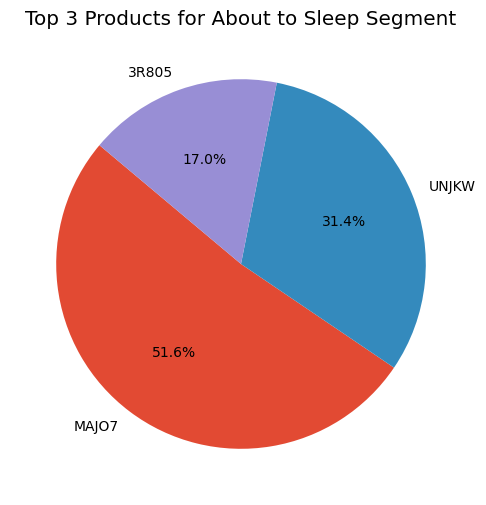

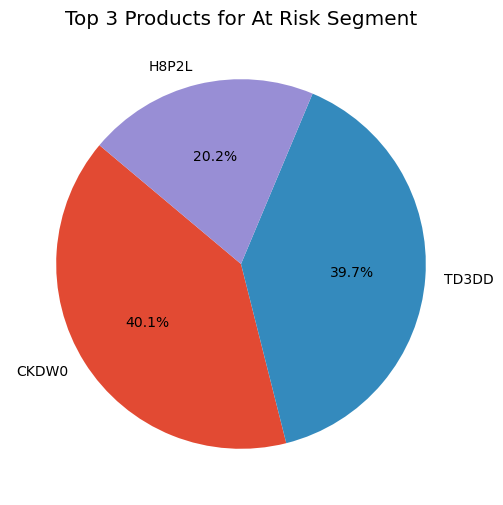

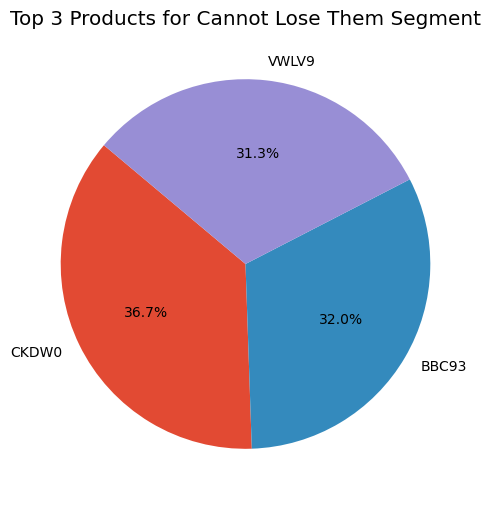

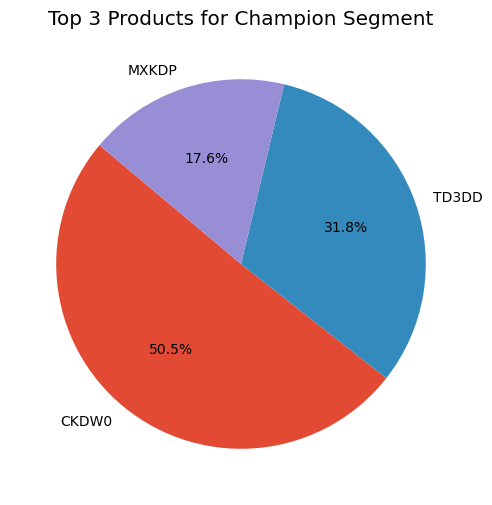

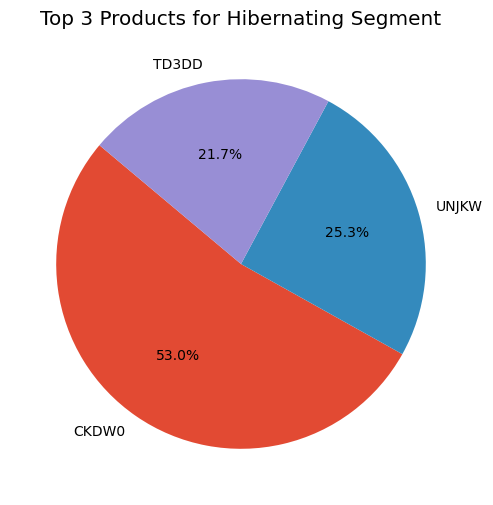

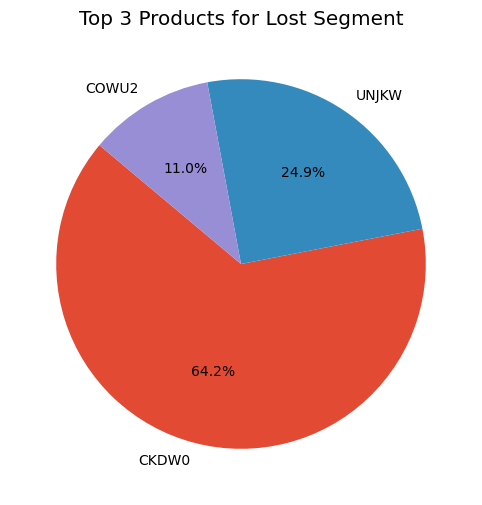

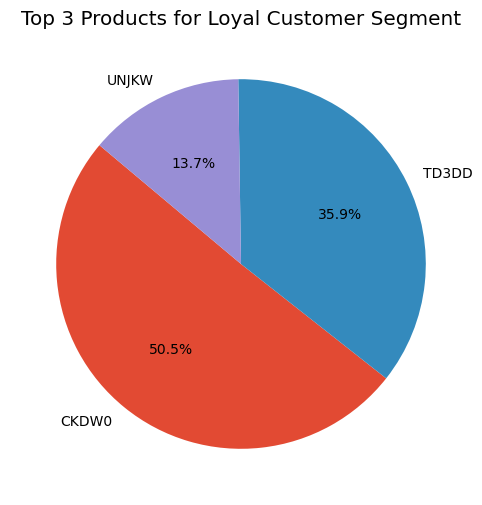

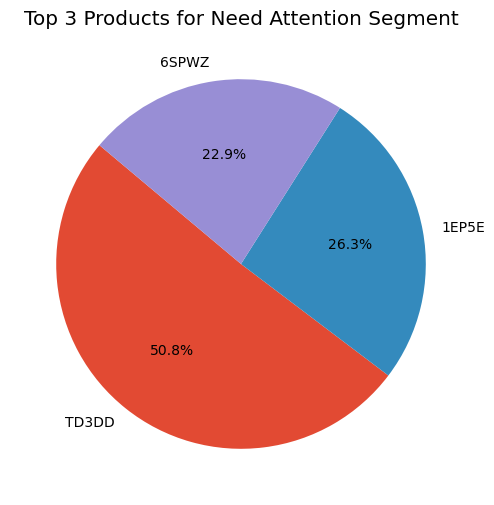

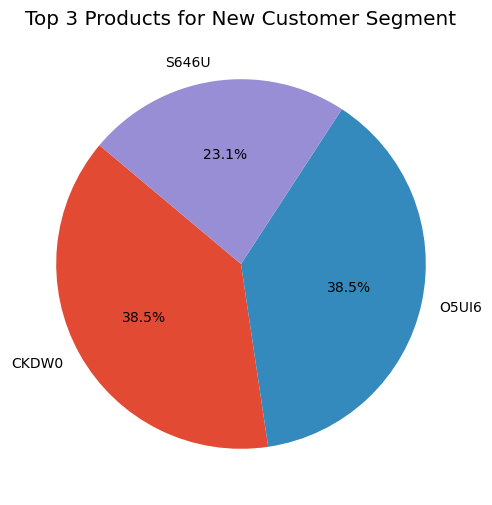

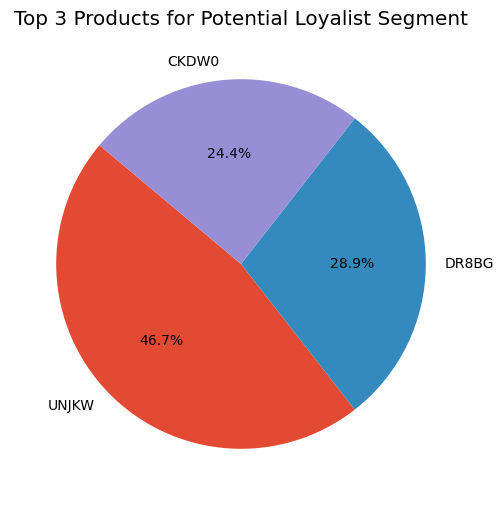

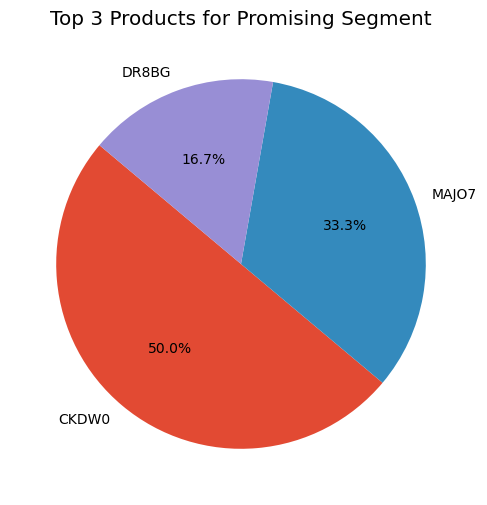

In [ ]:
# Get unique segments
segments = top_3_skus['Customer Segment'].unique()

# Loop through each segment and create a pie chart for top 3 products
for segment in segments:
    segment_data = top_3_skus[top_3_skus['Customer Segment'] == segment]
    plt.figure(figsize=(8, 6))
    plt.pie(segment_data['total_purchases'], labels=segment_data['SKU'], autopct='%1.1f%%', startangle=140)
    plt.title(f"Top 3 Products for {segment} Segment")
    plt.show()

Insights:
* CKDW0 is the most critical product, leading in multiple segments, making it the primary focus for both retention and recovery.
* TD3DD is a strong performer across many segments, indicating its potential for revenue maximization.
* UNJKW has mixed results, performing well in some segments but weak in others, requiring tailored engagement strategies.
* Products like COWU2, 3R805, and MXKDP need attention, as they lag behind in market share.

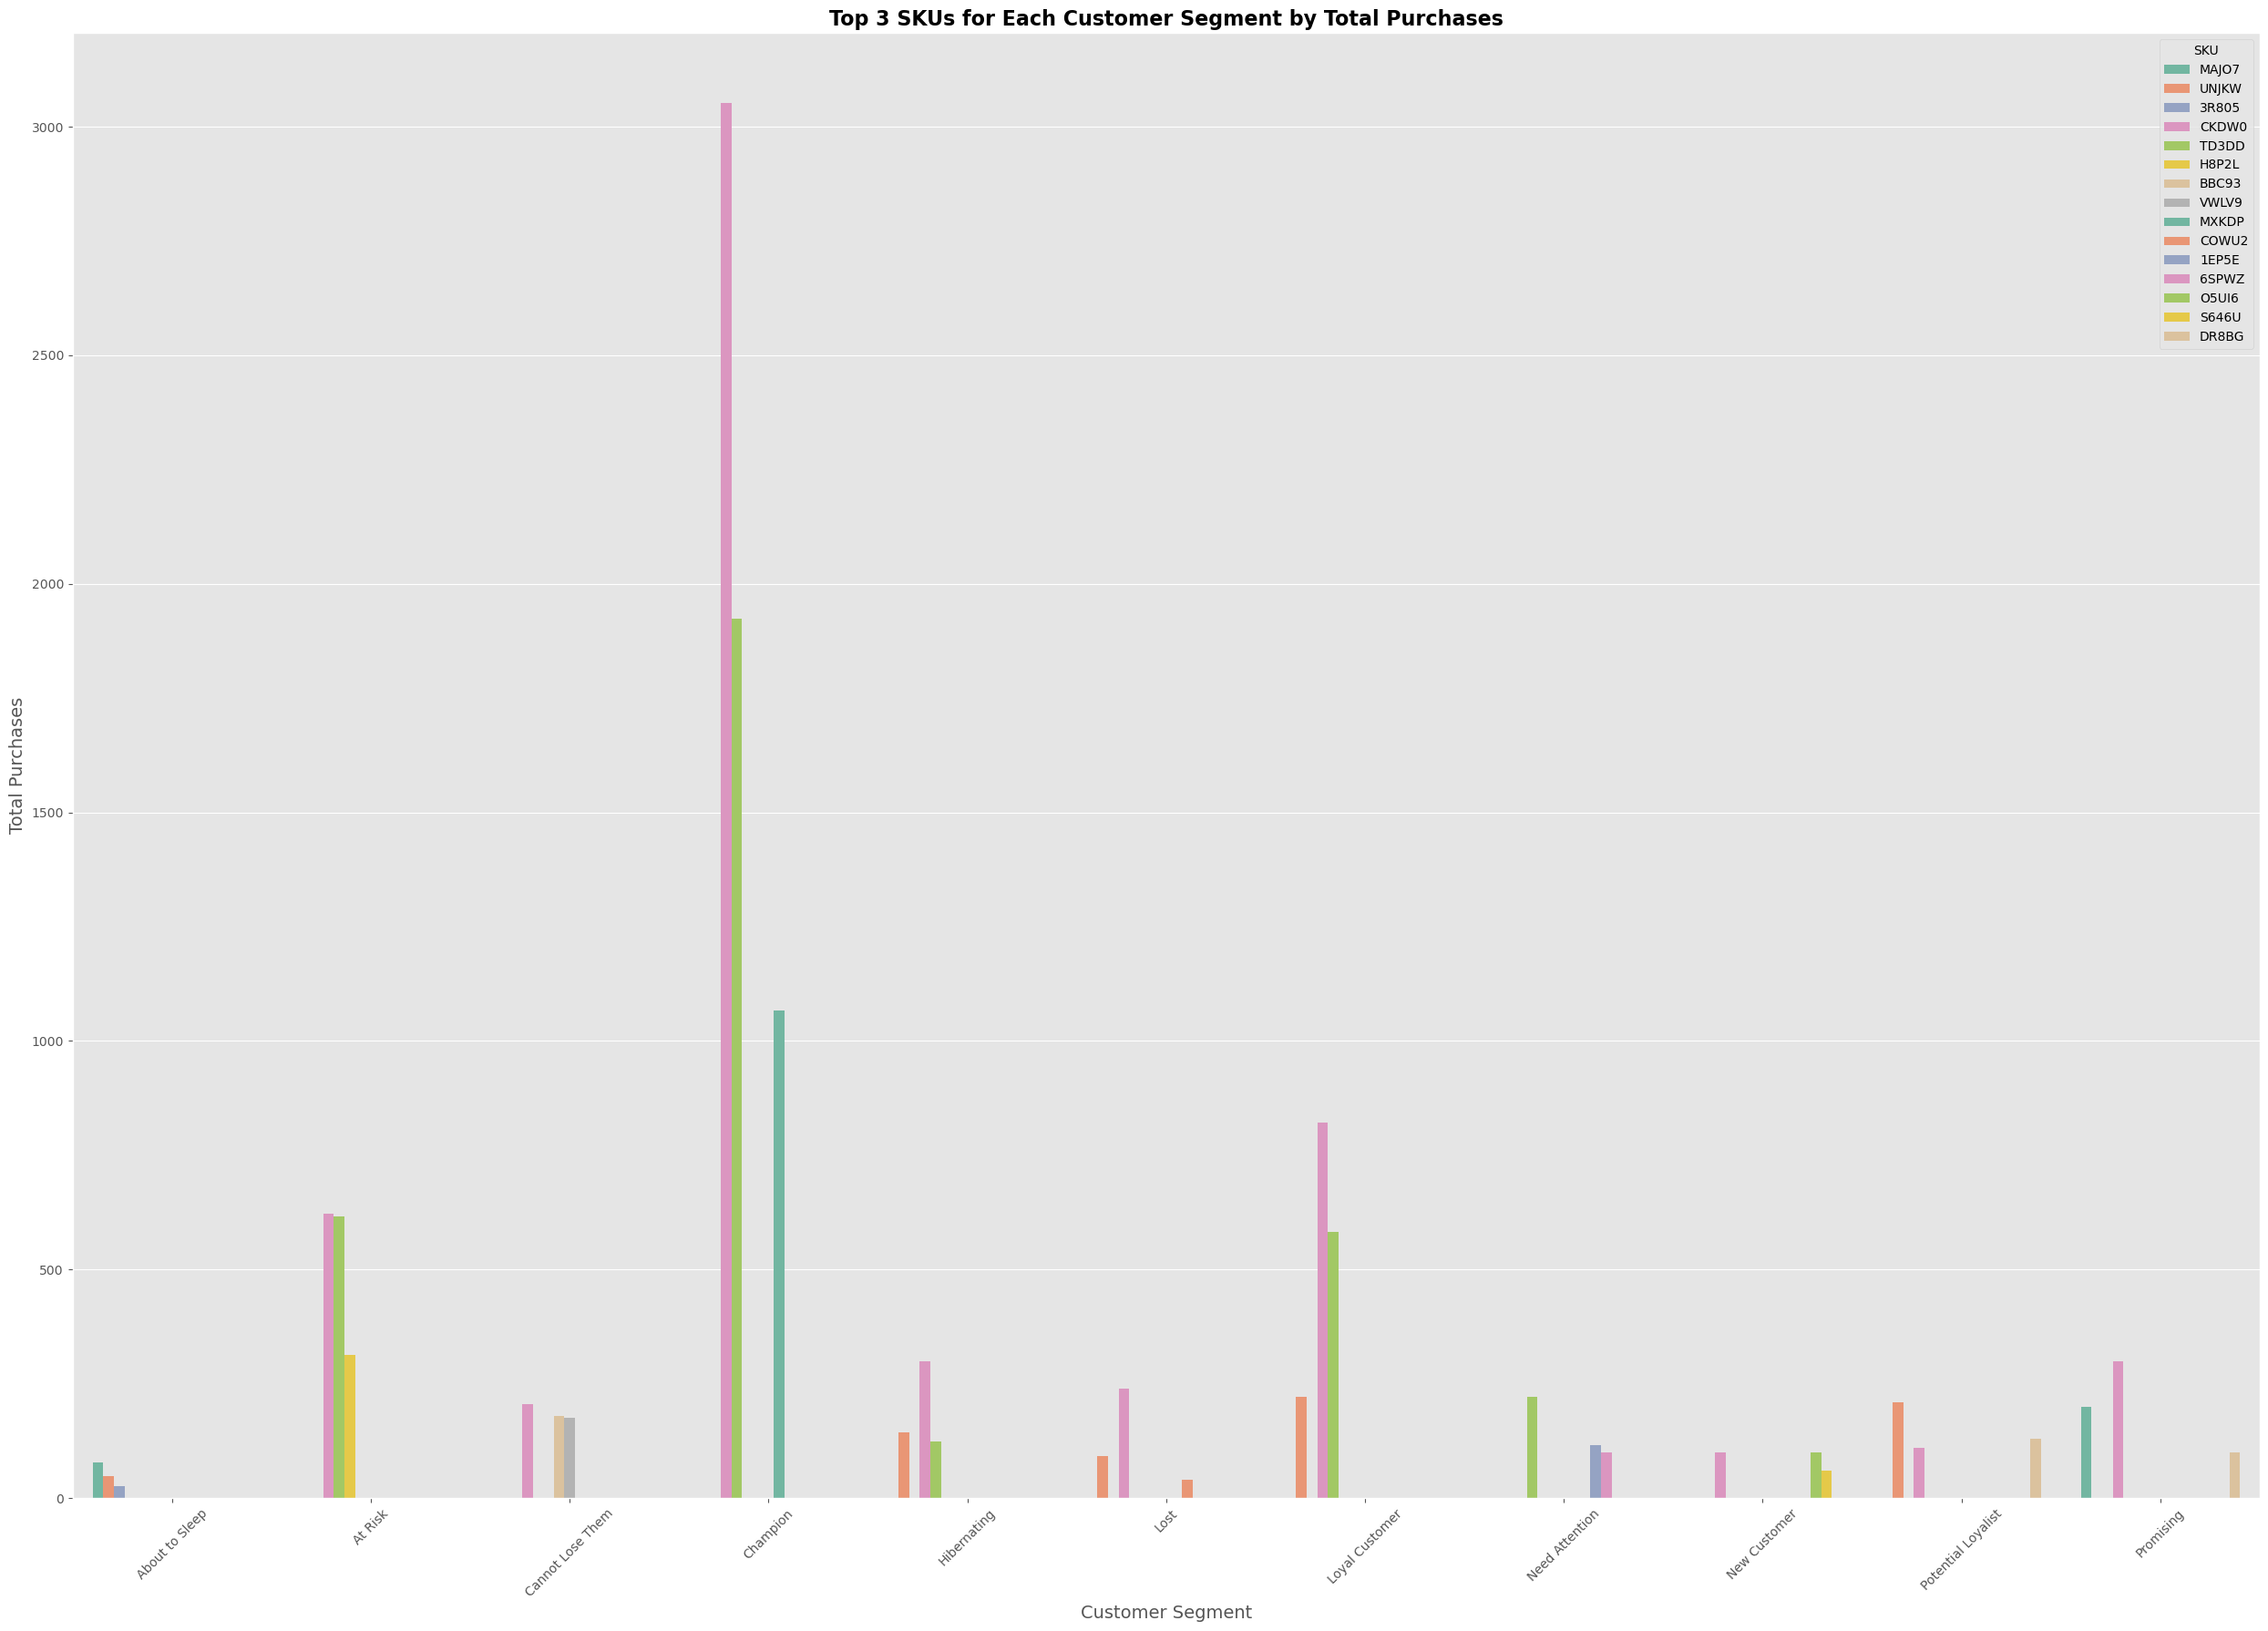

In [ ]:
# Step 5: Visualization
plt.figure(figsize=(25, 18))
sns.barplot(
    x='Customer Segment',
    y='total_purchases',
    hue='SKU',
    data=top_3_skus,
    dodge=True,  # Grouped bars
    palette='Set2'
)

# Add titles and labels
plt.title('Top 3 SKUs for Each Customer Segment by Total Purchases', fontsize=16, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=14)
plt.ylabel('Total Purchases', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='SKU')

# Display the plot
plt.tight_layout()
plt.show()

## Finding Best SKU to Offer the customer based on Max Purchases Amount - Average Purchases Amount

In [ ]:
# Step 1: Calculate average and max sales per customer
customer_sales = new_df.groupby(['Customer_ID', 'Customer Segment']).agg(
    avg_sales_amount=('Sales_Amount', 'mean'),
    max_sales_amount=('Sales_Amount', 'max')
).reset_index()

# Step 2: Calculate the leverage (potential spending gap)
customer_sales['leverage'] = customer_sales['max_sales_amount'] - customer_sales['avg_sales_amount']

# Step 3: Merge back to main data to get SKU-level details
df_with_leverage = new_df.merge(customer_sales, on='Customer_ID', how='left')

# Step 4: Identify SKUs with prices close to leverage (if SKU price data is available)
# Assuming 'SKU_Price' column exists in the data
df_with_leverage['price_gap'] = abs(df_with_leverage['leverage'] - df_with_leverage['Sales_Amount'])

# Step 5: Rank SKUs by price gap for each customer
df_with_leverage['SKU_Rank'] = df_with_leverage.groupby('Customer_ID')['price_gap'] \
    .rank(method='first', ascending=True)

# Step 6: Filter the best SKU suggestions (Rank 1)
sku_suggestions = df_with_leverage[df_with_leverage['SKU_Rank'] == 1]

# Drop duplicate Customer Segment column
sku_suggestions = sku_suggestions.drop(columns=['Customer Segment_y'])

# Rename Customer Segment_x to Segment
sku_suggestions = sku_suggestions.rename(columns={'Customer Segment_x': 'Segment'})

# Display the cleaned suggestions
sku_suggestions[['Customer_ID', 'Segment', 'SKU', 'Sales_Amount',
                       'avg_sales_amount', 'max_sales_amount', 'leverage', 'price_gap']]

,Customer_ID,Segment,SKU,Sales_Amount,avg_sales_amount,max_sales_amount,leverage,price_gap
4,9200,Hibernating,K8EHH,6.88,9.005000,11.13,2.125000,4.755000
5,5010,Lost,GVBRC,10.77,10.770000,10.77,0.000000,10.770000
23,9223,Hibernating,E63V3,1.62,6.060000,10.50,4.440000,2.820000
25,4921,Lost,NEYQ4,3.75,3.750000,3.75,0.000000,3.750000
30,2116,Lost,T5V5W,7.02,7.155000,7.29,0.135000,6.885000
...,...,...,...,...,...,...,...,...
131660,16584,Champion,IV3T1,45.70,10.942222,45.70,34.757778,10.942222
131665,10765,About to Sleep,6IISH,1.19,1.190000,1.19,0.000000,1.190000
131674,13690,Champion,TL4WZ,4.00,9.242500,12.38,3.137500,0.862500
131685,19901,Champion,N7AW3,27.93,24.375714,55.24,30.864286,2.934286


In [ ]:
# Drop duplicate Customer Segment column
df_with_leverage = df_with_leverage.drop(columns=['Customer Segment_y'])

# Rename Customer Segment_x to Segment
df_with_leverage = df_with_leverage.rename(columns={'Customer Segment_x': 'Segment'})

# Step 1: Identify the Top Product for Each Customer_ID
winning_products = df_with_leverage.groupby(['Customer_ID', 'Segment', 'SKU']).agg(
    total_purchases=('Quantity', 'sum'),
    total_sales=('Sales_Amount', 'sum')
).reset_index()

# Rank products within each Customer_ID and Segment
winning_products['Rank'] = winning_products.groupby(['Customer_ID', 'Segment'])['total_purchases'] \
    .rank(method='first', ascending=False)

# Filter only the top-ranked product for each Customer_ID and Segment
top_products = winning_products[winning_products['Rank'] == 1]

# Step 2: Identify the Top 3 SKUs for Each Segment
top_sku_by_segment = df_with_leverage.groupby(['Segment', 'SKU']).agg(
    total_purchases=('Quantity', 'sum'),
    total_sales=('Sales_Amount', 'sum')
).reset_index()

# Rank products within each Segment
top_sku_by_segment['Rank'] = top_sku_by_segment.groupby('Segment')['total_purchases'] \
    .rank(method='first', ascending=False)

# Filter the top 3 SKUs for each Segment
top_3_skus = top_sku_by_segment[top_sku_by_segment['Rank'] <= 3]

# Step 3: Merge the Best SKU per Segment into the main DataFrame
best_sku_per_segment = top_3_skus.groupby('Segment')['SKU'].first().reset_index().rename(columns={'SKU': 'Best_SKU'})
df_with_recommendation = df_with_leverage.merge(best_sku_per_segment, on='Segment', how='left')

# Step 4: Recommend SKU based on smallest price_gap and Segment Best SKU
def recommend_sku(row, top_products):
    # Filter rows for the current Customer_ID to find smallest price_gap SKU
    customer_data = top_products[top_products['Customer_ID'] == row['Customer_ID']]
    min_price_gap_sku = customer_data.loc[customer_data['total_purchases'].idxmax(), 'SKU'] \
        if not customer_data.empty else row['Best_SKU']
    return min_price_gap_sku

# Apply the recommendation logic
df_with_recommendation['Best_SKU_Recommendation'] = df_with_recommendation.apply(
    lambda row: recommend_sku(row, top_products), axis=1
)

# Step 5: Display the Final Recommendations
final_recommendations = df_with_recommendation[['Customer_ID', 'Segment', 'SKU',
                                                'Best_SKU_Recommendation', 'Sales_Amount', 'price_gap']]
final_recommendations.head(10)

,Customer_ID,Segment,SKU,Best_SKU_Recommendation,Sales_Amount,price_gap
0,2547,At Risk,0EM7L,UQC6F,3.13,6.965000
1,822,At Risk,68BRQ,536VK,5.46,3.190000
2,3686,Cannot Lose Them,CZUZX,L9VPF,6.35,15.571200
3,3719,Cannot Lose Them,549KK,707VJ,5.59,21.848511
4,9200,Hibernating,K8EHH,K8EHH,6.88,4.755000
5,5010,Lost,GVBRC,GVBRC,10.77,10.770000
6,1666,Champion,AHAE7,VUD1P,3.65,14.788899
7,1666,Champion,AHZNS,VUD1P,8.21,10.228899
8,1253,Cannot Lose Them,9STQJ,6DCYD,8.25,10.229048
9,5541,At Risk,7IE9S,6I4Z1,8.18,40.895667


In [ ]:
df_with_recommendation['Best_SKU_Recommendation'].unique()

array(['UQC6F', '536VK', 'L9VPF', ..., 'P2HBZ', 'EQTNO', 'UPB37'],
      dtype=object)

## Additional Inisght

**Finding the best customer type that generate the most revenue**

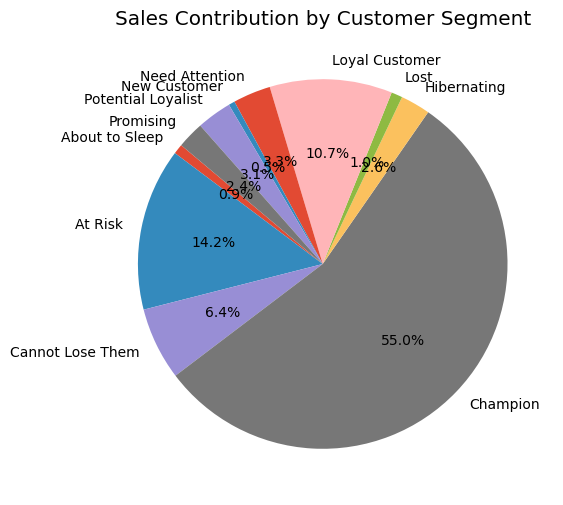

In [ ]:
segment_sales = new_df.groupby('Customer Segment').agg(
    total_sales=('Sales_Amount', 'sum')
).reset_index()

# Visualize
plt.figure(figsize=(10, 6))
plt.pie(segment_sales['total_sales'], labels=segment_sales['Customer Segment'], autopct='%1.1f%%', startangle=140)
plt.title('Sales Contribution by Customer Segment')
plt.show()